In [1]:
import numpy as np
import mnist

In [2]:
class Neuron(object):
    """
    A simple artificial neuron, processing an input vector and returning a corresponding activation.
    Args:
        num_inputs (int): The input vector size / number of input values.
        activation_function (callable): The activation function defining this neuron.
    Attributes:
        W (ndarray): The weight values for each input.
        b (float): The bias value, added to the weighted sum.
        activation_function (callable): The activation function computing the neuron's output.
    """

    def __init__(self, num_inputs, activation_function):
        super().__init__()

        # Randomly initializing the weight vector and the bias value (e.g., using a simplistic 
        # uniform distribution between -1 and 1):
        self.W = np.random.uniform(size=num_inputs, low=-1., high=1.)
        self.b = np.random.uniform(size=1, low=-1., high=1.)

        self.activation_function = activation_function

    def forward(self, x):
        """
        Forward the input signal through the neuron, returning its activation value.
        Args:
            x (ndarray): The input vector, of shape `(1, num_inputs)`
        Returns:
            activation (ndarray): The activation value, of shape `(1, layer_size)`.
        """
        z = np.dot(x, self.W) + self.b
        return self.activation_function(z)

In [3]:
class FullyConnectedLayer(object):
    """A simple fully-connected NN layer.
    Args:
        num_inputs (int): The input vector size / number of input values.
        layer_size (int): The output vector size / number of neurons in the layer.
        activation_function (callable): The activation function for this layer.
    Attributes:
        W (ndarray): The weight values for each input.
        b (ndarray): The bias value, added to the weighted sum.
        size (int): The layer size / number of neurons.
        activation_function (callable): The activation function computing the neuron's output.
        x (ndarray): The last provided input vector, stored for backpropagation.
        y (ndarray): The corresponding output, also stored for backpropagation.
        derivated_activation_function (callable): The corresponding derivated function for backpropagation.
        dL_dW (ndarray): The derivative of the loss, with respect to the weights W.
        dL_db (ndarray): The derivative of the loss, with respect to the bias b.
    """

    def __init__(self, num_inputs, layer_size, activation_function, derivated_activation_function=None):
        super().__init__()

        # Randomly initializing the weight vector and the bias value (using a normal distribution this time):
        self.W = np.random.standard_normal((num_inputs, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.size = layer_size

        self.activation_function = activation_function
        self.derivated_activation_function = derivated_activation_function
        self.x, self.y = None, None
        self.dL_dW, self.dL_db = None, None

    def forward(self, x):
        """
        Forward the input vector through the layer, returning its activation vector.
        Args:
            x (ndarray): The input vector, of shape `(batch_size, num_inputs)`
        Returns:
            activation (ndarray): The activation value, of shape `(batch_size, layer_size)`.
        """
        z = np.dot(x, self.W) + self.b
        self.y = self.activation_function(z)
        self.x = x  # (we store the input and output values for back-propagation)
        return self.y

    def backward(self, dL_dy):
        """
        Back-propagate the loss, computing all the derivatives, storing those w.r.t. the layer parameters,
        and returning the loss w.r.t. its inputs for further propagation.
        Args:
            dL_dy (ndarray): The loss derivative w.r.t. the layer's output (dL/dy = l'_{k+1}).
        Returns:
            dL_dx (ndarray): The loss derivative w.r.t. the layer's input (dL/dx).
        """
        dy_dz = self.derivated_activation_function(self.y)  # = f'
        dL_dz = (dL_dy * dy_dz) # dL/dz = dL/dy * dy/dz = l'_{k+1} * f'
        dz_dw = self.x.T
        dz_dx = self.W.T
        dz_db = np.ones(dL_dy.shape[0]) # dz/db = d(W.x + b)/db = 0 + db/db = "ones"-vector

        # Computing the derivatives with respect to the layer's parameters, and storing them for opt. optimization:
        self.dL_dW = np.dot(dz_dw, dL_dz)
        self.dL_db = np.dot(dz_db, dL_dz)

        # Computing the derivative with respect to the input, to be passed to the previous layers (their `dL_dy`):
        dL_dx = np.dot(dL_dz, dz_dx)
        return dL_dx

    def optimize(self, epsilon):
        """
        Optimize the layer's parameters, using the stored derivative values.
        Args:
            epsilon (float): The learning rate.
        """
        self.W -= epsilon * self.dL_dW
        self.b -= epsilon * self.dL_db

In [4]:
def sigmoid(x):             # sigmoid function
    y = 1 / (1 + np.exp(-x))
    return y


def derivated_sigmoid(y):   # sigmoid derivative function
    return y * (1 - y)

In [5]:
def loss_L2(pred, target):             # L2 loss function
    return np.sum(np.square(pred - target)) / pred.shape[0] # opt. we divide by the batch size


def derivated_loss_L2(pred, target):   # L2 derivative function
    return 2 * (pred - target)

In [6]:
def binary_cross_entropy(pred, target):            # cross-entropy loss function
    return -np.mean(np.multiply(np.log(pred), target) + np.multiply(np.log(1 - pred), (1 - target)))


def derivated_binary_cross_entropy(pred, target):  # cross-entropy derivative function
    return (pred - target) / (pred * (1 - pred))

In [7]:
class SimpleNetwork(object):
    """A simple fully-connected NN.
    Args:
        num_inputs (int): The input vector size / number of input values.
        num_outputs (int): The output vector size.
        hidden_layers_sizes (list): A list of sizes for each hidden layer to add to the network
        activation_function (callable): The activation function for all the layers
        derivated_activation_function (callable): The derivated activation function
        loss_function (callable): The loss function to train this network
        derivated_loss_function (callable): The derivative of the loss function, for back-propagation
    Attributes:
        layers (list): The list of layers forming this simple network.
        loss_function (callable): The loss function to train this network.
        derivated_loss_function (callable): The derivative of the loss function, for back-propagation.
    """

    def __init__(self, num_inputs, num_outputs, hidden_layers_sizes=(64, 32),
                 activation_function=sigmoid, derivated_activation_function=derivated_sigmoid,
                 loss_function=loss_L2, derivated_loss_function=derivated_loss_L2):
        super().__init__()
        # We build the list of layers composing the network, according to the provided arguments:
        layer_sizes = [num_inputs, *hidden_layers_sizes, num_outputs]
        self.layers = [
            FullyConnectedLayer(layer_sizes[i], layer_sizes[i + 1], 
                                activation_function, derivated_activation_function)
            for i in range(len(layer_sizes) - 1)]

        self.loss_function = loss_function
        self.derivated_loss_function = derivated_loss_function

    def forward(self, x):
        """
        Forward the input vector through the layers, returning the output vector.
        Args:
            x (ndarray): The input vector, of shape `(batch_size, num_inputs)`.
        Returns:
            activation (ndarray): The output activation value, of shape `(batch_size, layer_size)`.
        """
        for layer in self.layers: # from the input layer to the output one
            x = layer.forward(x)
        return x

    def predict(self, x):
        """
        Compute the output corresponding to input `x`, and return the index of the largest 
        output value.
        Args:
            x (ndarray): The input vector, of shape `(1, num_inputs)`.
        Returns:
            best_class (int): The predicted class ID.
        """
        estimations = self.forward(x)
        best_class = np.argmax(estimations)
        return best_class

    def backward(self, dL_dy):
        """
        Back-propagate the loss hrough the layers (require `forward()` to be called before).
        Args:
            dL_dy (ndarray): The loss derivative w.r.t. the network's output (dL/dy).
        Returns:
            dL_dx (ndarray): The loss derivative w.r.t. the network's input (dL/dx).
        """
        for layer in reversed(self.layers): # from the output layer to the input one
            dL_dy = layer.backward(dL_dy)
        return dL_dy

    def optimize(self, epsilon):
        """
        Optimize the network parameters according to the stored gradients (require `backward()`
        to be called before).
        Args:
            epsilon (float): The learning rate.
        """
        for layer in self.layers:             # the order doesn't matter here
            layer.optimize(epsilon)

    def evaluate_accuracy(self, X_val, y_val):
        """
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
        Returns:
            accuracy (float): The accuracy of the network 
                              (= number of correct predictions/dataset size).
        """
        num_corrects = 0
        for i in range(len(X_val)):
            pred_class = self.predict(X_val[i])
            if pred_class == y_val[i]:
                num_corrects += 1
        return num_corrects / len(X_val)

    def train(self, X_train, y_train, X_val=None, y_val=None, 
              batch_size=32, num_epochs=5, learning_rate=1e-3, print_frequency=20):
        """
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_train (ndarray): The input training dataset.
            y_train (ndarray): The corresponding ground-truth training dataset.
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
            batch_size (int): The mini-batch size.
            num_epochs (int): The number of training epochs i.e. iterations over the whole dataset.
            learning_rate (float): The learning rate to scale the derivatives.
            print_frequency (int): Frequency to print metrics (in epochs).
        Returns:
            losses (list): The list of training losses for each epoch.
            accuracies (list): The list of validation accuracy values for each epoch.
        """
        num_batches_per_epoch = len(X_train) // batch_size
        do_validation = X_val is not None and y_val is not None
        losses, accuracies = [], []
        for i in range(num_epochs): # for each training epoch
            epoch_loss = 0
            for b in range(num_batches_per_epoch):  # for each batch composing the dataset
                # Get batch:
                batch_index_begin = b * batch_size
                batch_index_end = batch_index_begin + batch_size
                x = X_train[batch_index_begin: batch_index_end]
                targets = y_train[batch_index_begin: batch_index_end]
                # Optimize on batch:
                predictions = y = self.forward(x)  # forward pass
                L = self.loss_function(predictions, targets)  # loss computation
                dL_dy = self.derivated_loss_function(predictions, targets)  # loss derivation
                self.backward(dL_dy)  # back-propagation pass
                self.optimize(learning_rate)  # optimization of the NN
                epoch_loss += L

            # Logging training loss and validation accuracy, to follow the training:
            epoch_loss /= num_batches_per_epoch
            losses.append(epoch_loss)
            if do_validation:
                accuracy = self.evaluate_accuracy(X_val, y_val)
                accuracies.append(accuracy)
            else:
                accuracy = np.NaN
            if i % print_frequency == 0 or i == (num_epochs - 1):
                print("Epoch {:4d}: training loss = {:.6f} | val accuracy = {:.2f}%".format(
                    i, epoch_loss, accuracy * 100))
        return losses, accuracies


In [8]:
import matplotlib          # We use this package to visualize some data and results
import matplotlib.pyplot as plt
import mnist

np.random.seed(42)

In [9]:
X_train, y_train = mnist.train_images(), mnist.train_labels()
X_test,  y_test  = mnist.test_images(), mnist.test_labels()
num_classes = 10    # classes are the digits from 0 to 9

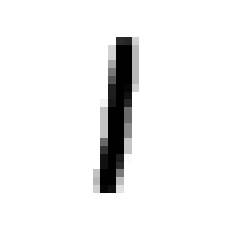

In [10]:
img_idx = np.random.randint(0, X_test.shape[0])
plt.imshow(X_test[img_idx], cmap=matplotlib.cm.binary)
plt.axis("off")
plt.show()

In [11]:
y_test[img_idx]


1

In [12]:
X_train, X_test = X_train.reshape(-1, 28 * 28), X_test.reshape(-1, 28 * 28)


In [13]:
X_train, X_test = X_train / 255., X_test / 255.
print("Normalized pixel values between {} and {}".format(X_train.min(), X_train.max()))

Normalized pixel values between 0.0 and 1.0


In [14]:
y_train = np.eye(num_classes)[y_train]


In [15]:

mnist_classifier = SimpleNetwork(num_inputs=X_train.shape[1], 
                                 num_outputs=num_classes, hidden_layers_sizes=[64, 32])

In [16]:
predictions = mnist_classifier.forward(X_train)                         # forward pass
loss_untrained = mnist_classifier.loss_function(predictions, y_train)   # loss computation

accuracy_untrained = mnist_classifier.evaluate_accuracy(X_test, y_test)  # Accuracy
print("Untrained : training loss = {:.6f} | val accuracy = {:.2f}%".format(
    loss_untrained, accuracy_untrained * 100))

Untrained : training loss = 4.436700 | val accuracy = 12.19%


In [18]:
losses, accuracies = mnist_classifier.train(X_train, y_train, X_test, y_test, 
                                            batch_size=30, num_epochs=500)

Epoch    0: training loss = 1.096978 | val accuracy = 19.10%
Epoch   20: training loss = 0.252953 | val accuracy = 84.89%
Epoch   40: training loss = 0.177532 | val accuracy = 88.92%
Epoch   60: training loss = 0.146596 | val accuracy = 90.50%


KeyboardInterrupt: 